In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install deeplake[enterprise]

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

\

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



|

hub://activeloop/nih-chest-xray-train loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



/

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

77872
8652
25596


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs)
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_ftrs = model.fc.in_features
num_labels = 15

model.fc = nn.Sequential(
  nn.Linear(2048, 1000),
  nn.ReLU(),
  nn.Linear(1000, num_labels),
  nn.Sigmoid()
)

for name, param in model.named_parameters():
  if ('layer3' in name) or ('layer4' in name) or ('fc' in name):
    param.requires_grad = True
  else:
    param.requires_grad = False

for param in model.conv1.parameters():
  param.requires_grad = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

criterion = class_averaged_binary_cross_entropy
optimizer = optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

model = model.to(device)

Running on cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [00:53<00:00, 40.5MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1868
Validation phase completed. Average loss: 0.1821
Micro-averaged ROC AUC: 0.8899724186440462
Macro-averaged ROC AUC: 0.7116207306585633
ROC AUC for label 0: 0.7273186930808505
ROC AUC for label 1: 0.831105324074074
ROC AUC for label 2: 0.7098325062034739
ROC AUC for label 3: 0.5826427225866229
ROC AUC for label 4: 0.653179535900811
ROC AUC for label 5: 0.7465931720828257
ROC AUC for label 6: 0.665349066090417
ROC AUC for label 7: 0.8384441728879581
ROC AUC for label 8: 0.6472333468533435
ROC AUC for label 9: 0.7057257795762915
ROC AUC for label 10: 0.731863328235809
ROC AUC for label 11: 0.7229872285912234
ROC AUC for label 12: 0.6209597373980935
ROC AUC for label 13: 0.6660410449188857
ROC AUC for label 14: 0.8250353013977697


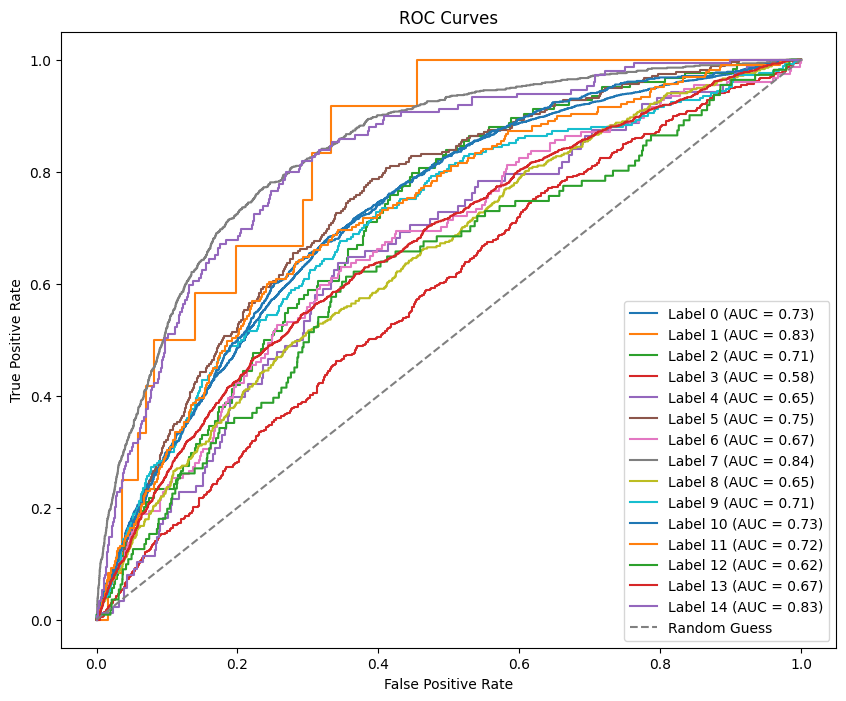

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Loss_Unbalanced_ResNet50_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1801
Validation phase completed. Average loss: 0.1778
Micro-averaged ROC AUC: 0.8948157494543061
Macro-averaged ROC AUC: 0.72652745200563
ROC AUC for label 0: 0.728788122951527
ROC AUC for label 1: 0.755372299382716
ROC AUC for label 2: 0.7423430596743931
ROC AUC for label 3: 0.6384141741975882
ROC AUC for label 4: 0.6463393274170948
ROC AUC for label 5: 0.7469926614237627
ROC AUC for label 6: 0.7113270349325892
ROC AUC for label 7: 0.8549186936217468
ROC AUC for label 8: 0.6911150289440561
ROC AUC for label 9: 0.7457838609854796
ROC AUC for label 10: 0.7403811901832262
ROC AUC for label 11: 0.7439009660256998
ROC AUC for label 12: 0.6503321023868968
ROC AUC for label 13: 0.6702252161769208
ROC 

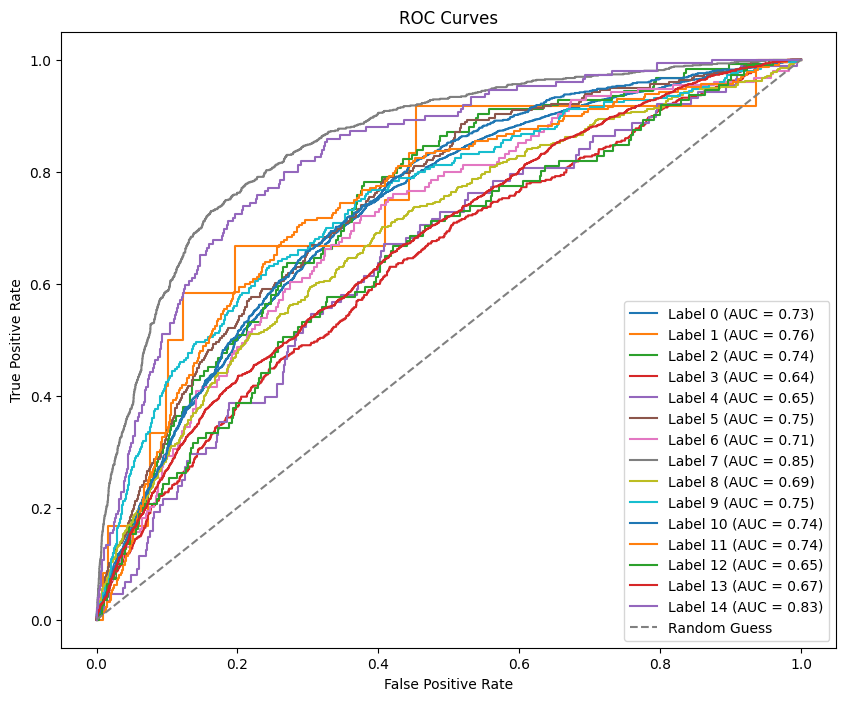

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Loss_Unbalanced_ResNet50_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1771
Validation phase completed. Average loss: 0.1744
Micro-averaged ROC AUC: 0.9013130325493465
Macro-averaged ROC AUC: 0.7529049847034252
ROC AUC for label 0: 0.7388831265267233
ROC AUC for label 1: 0.8101851851851852
ROC AUC for label 2: 0.7620750242086788
ROC AUC for label 3: 0.6537273221249548
ROC AUC for label 4: 0.6747749564774319
ROC AUC for label 5: 0.767666879154904
ROC AUC for label 6: 0.7982374768089054
ROC AUC for label 7: 0.8667937967934926
ROC AUC for label 8: 0.7366167879012566
ROC AUC for label 9: 0.7553615805760533
ROC AUC for label 10: 0.7554775604124186
ROC AUC for label 11: 0.7664636139034495
ROC AUC for label 12: 0.6644231164779111
ROC AUC for label 13: 0.6750462006427915
R

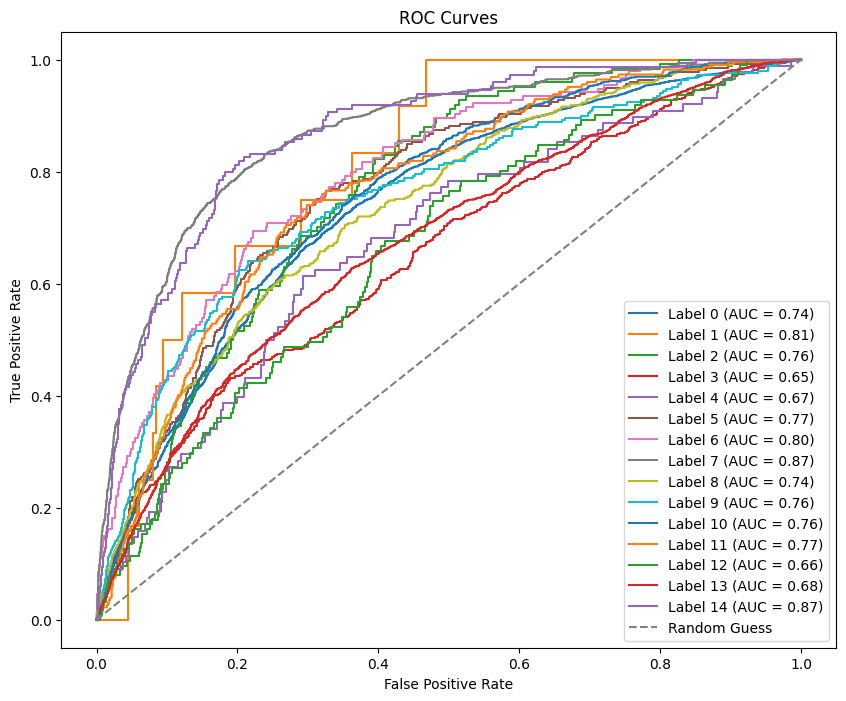

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Loss_Unbalanced_ResNet50_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1746
Validation phase completed. Average loss: 0.1749
Micro-averaged ROC AUC: 0.9010879020529561
Macro-averaged ROC AUC: 0.7581430502775505
ROC AUC for label 0: 0.7414079712786698
ROC AUC for label 1: 0.8522665895061728
ROC AUC for label 2: 0.7514326620468439
ROC AUC for label 3: 0.6620159861579684
ROC AUC for label 4: 0.6666516283809605
ROC AUC for label 5: 0.7707914871828355
ROC AUC for label 6: 0.8310267045263515
ROC AUC for label 7: 0.8669313356466339
ROC AUC for label 8: 0.7408792229209499
ROC AUC for label 9: 0.7444403713401571
ROC AUC for label 10: 0.7541319619282634
ROC AUC for label 11: 0.7621961071386554
ROC AUC for label 12: 0.6794666109734603
ROC AUC for label 13: 0.6813208792470157


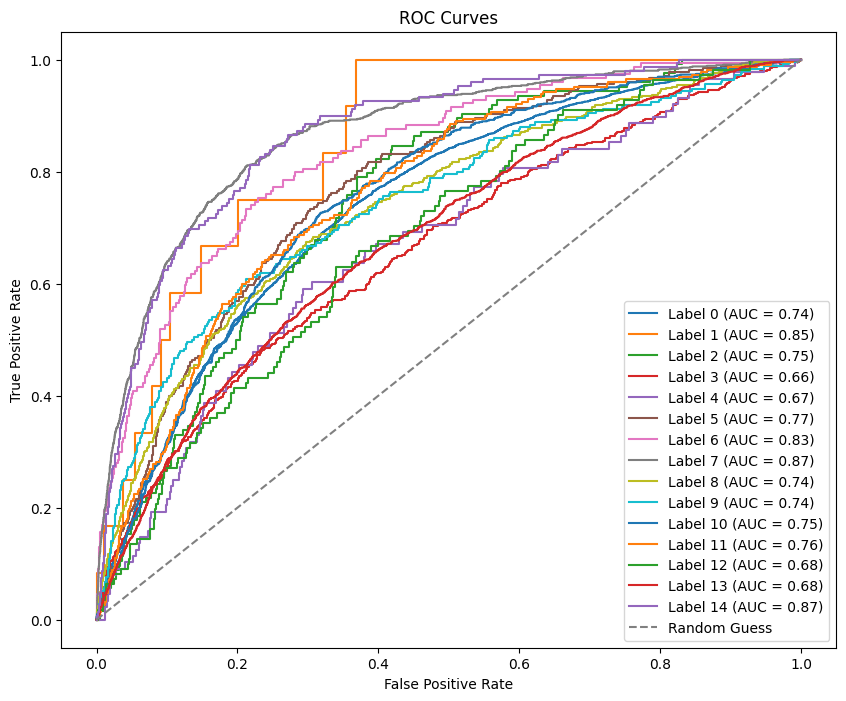

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Loss_Unbalanced_ResNet50_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1725
Validation phase completed. Average loss: 0.1722
Micro-averaged ROC AUC: 0.9052457597116287
Macro-averaged ROC AUC: 0.7677849023857272
ROC AUC for label 0: 0.7465416470735347
ROC AUC for label 1: 0.8507619598765432
ROC AUC for label 2: 0.7887367230527145
ROC AUC for label 3: 0.6664008982367697
ROC AUC for label 4: 0.6684190692539596
ROC AUC for label 5: 0.7672613759959312
ROC AUC for label 6: 0.8458315631179835
ROC AUC for label 7: 0.8705407974182977
ROC AUC for label 8: 0.761606386403441
ROC AUC for label 9: 0.7641156867412521
ROC AUC for label 10: 0.7691980976032523
ROC AUC for label 11: 0.7836222695721513
ROC AUC for label 12: 0.6783411440945688
ROC AUC for label 13: 0.6807626453933272
R

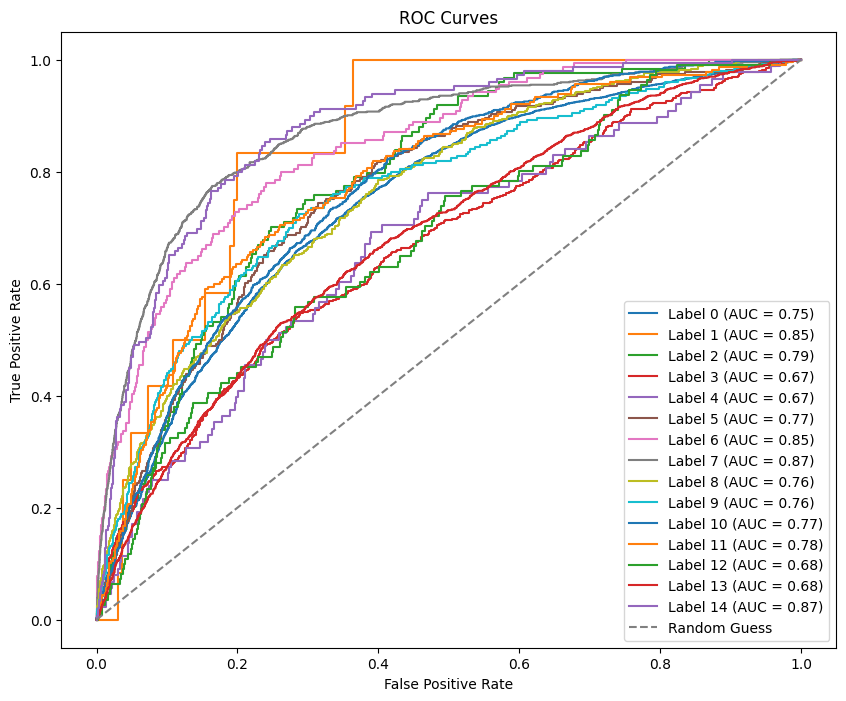

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Loss_Unbalanced_ResNet50_checkpoint_epoch_5.pt


In [ ]:
num_epochs = 5
model_name = "SSN_Sigmoid_BCE_Avg_Loss_Unbalanced_ResNet50"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_Sigmoid_BCE_Avg_Loss_Unbalanced_ResNet50.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)